## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [3]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (124 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [4]:
!pip install scipy==1.1.0 

     |████████████████████████████████| 31.2MB 106kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [6]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [7]:
dir='/content/drive/MyDrive/slides'

In [8]:

import os
files = os.listdir(dir)
print(len(files))
print(files)


67
['tumor_091_mask.tif', 'tumor_091.tif', 'tumor_001_mask.tif', 'tumor_001.tif', 'tumor_002_mask.tif', 'tumor_002.tif', 'tumor_005_mask.tif', 'tumor_005.tif', 'tumor_012_mask.tif', 'tumor_012.tif', 'tumor_016_mask.tif', 'tumor_016.tif', 'tumor_019_mask.tif', 'tumor_059.xml', 'tumor_002.xml', 'tumor_075.xml', 'tumor_023.xml', 'tumor_057.xml', 'tumor_005.xml', 'tumor_035.xml', 'tumor_019.xml', 'tumor_012.xml', 'tumor_016.xml', 'tumor_001.xml', 'tumor_081.xml', 'tumor_084.xml', 'tumor_019.tif', 'tumor_091.xml', 'tumor_094.xml', 'tumor_110.xml', 'tumor_096.xml', 'tumor_101.xml', 'tumor_099.xml', 'tumor_023_mask.tif', 'tumor_023.tif', 'tumor_031_mask.tif', 'tumor_031.tif', 'tumor_035_mask.tif', 'tumor_035.tif', 'tumor_038.tif', 'tumor_038 (1).xml', 'tumor_057_mask.tif', 'tumor_057.tif', 'tumor_059_mask.tif', 'tumor_059.tif', 'tumor_064_mask.tif', 'tumor_064.tif', 'tumor_075_mask.tif', 'tumor_075.tif', 'tumor_078_mask.tif', 'tumor_078.tif', 'tumor_081_mask.tif', 'tumor_081.tif', 'tumor_084_

In [9]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

Reading test slide and visualizing it

In [10]:
slide_path1=dir+'/'+'tumor_091.tif'
tumor_mask_path1=dir+'/'+'tumor_091_mask.tif'

In [11]:
my_zoom_level = 4

slide_test = open_slide(slide_path1)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path1, 
                                                        slide_test.level_dimensions[0][0], 
                                                        slide_test.level_dimensions[0][1]))

tumor_mask_test = open_slide(tumor_mask_path1)
print ("Read tumor mask from %s" % (tumor_mask_path1))

print("Slide includes %d levels", len(slide_test.level_dimensions))
for i in range(len(slide_test.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide_test.level_dimensions[i], 
                                                             slide_test.level_downsamples[i]))
    assert tumor_mask_test.level_dimensions[i][0] == slide_test.level_dimensions[i][0]
    assert tumor_mask_test.level_dimensions[i][1] == slide_test.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide_test.level_dimensions[my_zoom_level]
assert width * slide_test.level_downsamples[my_zoom_level] == slide_test.level_dimensions[0][0]
assert height * slide_test.level_downsamples[my_zoom_level] == slide_test.level_dimensions[0][1]

Read WSI from /content/drive/MyDrive/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/MyDrive/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


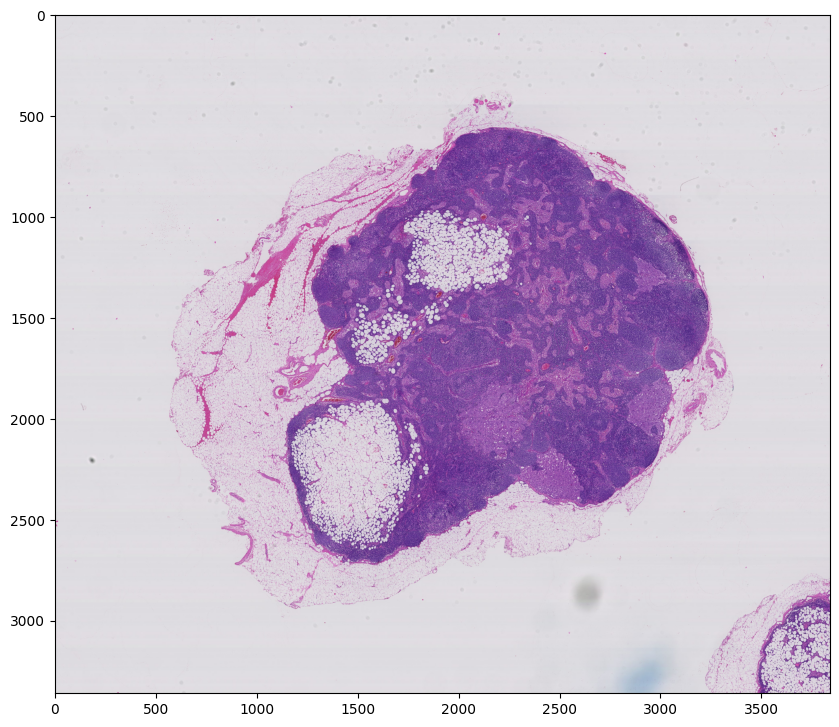

In [12]:


slide_image_test = read_slide(slide_test, 
                         x=0, 
                         y=0, 
                         level=my_zoom_level, 
                         width=slide_test.level_dimensions[my_zoom_level][0], 
                         height=slide_test.level_dimensions[my_zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_test)

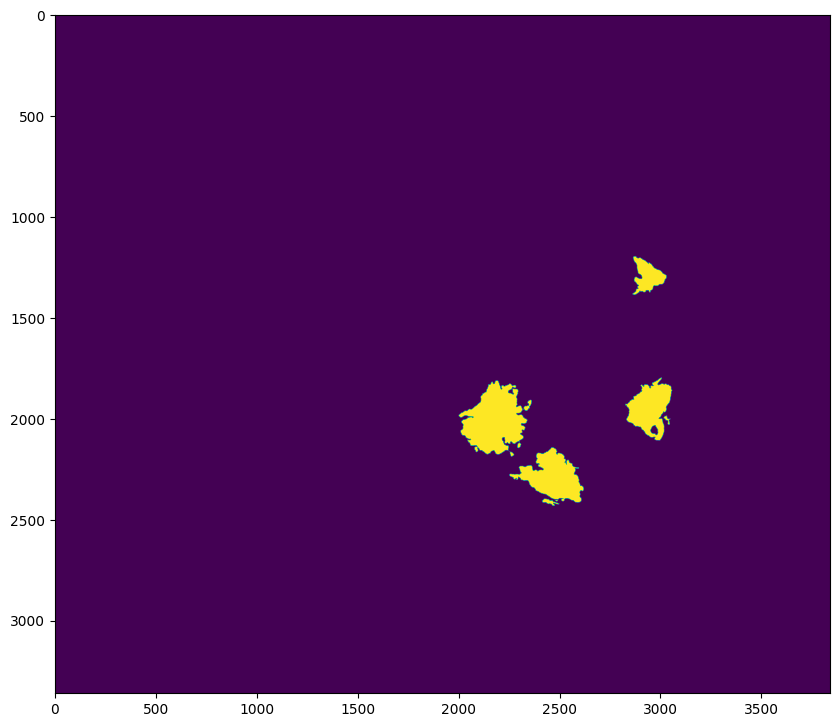

In [13]:
mask_image_test = read_slide(tumor_mask_test, 
                        x=0, 
                        y=0, 
                        level=my_zoom_level, 
                        width=slide_test.level_dimensions[my_zoom_level][0], 
                        height=slide_test.level_dimensions[my_zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image_test = mask_image_test[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image_test)

Reading train slide and visualizing it

In [14]:

slide_path = dir+'/'+"tumor_110.tif"
tumor_mask_path = dir+'/'+"tumor_110_mask.tif"

In [15]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[my_zoom_level]
assert width * slide.level_downsamples[my_zoom_level] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[my_zoom_level] == slide.level_dimensions[0][1]

Read WSI from /content/drive/MyDrive/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/drive/MyDrive/slides/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


Read WSI from /content/drive/MyDrive/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/drive/MyDrive/slides/tumor_110_mask.tif


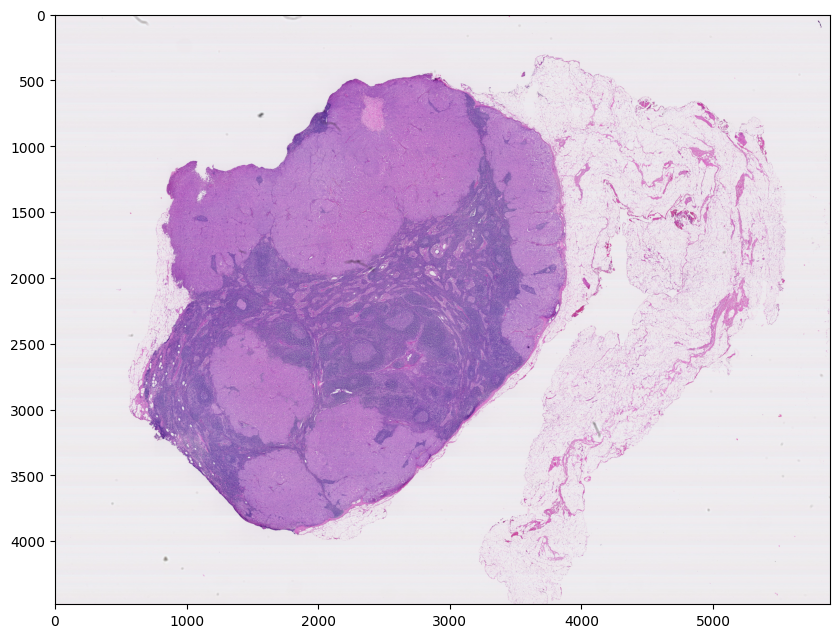

In [16]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))



slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=my_zoom_level, 
                         width=slide.level_dimensions[my_zoom_level][0], 
                         height=slide.level_dimensions[my_zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

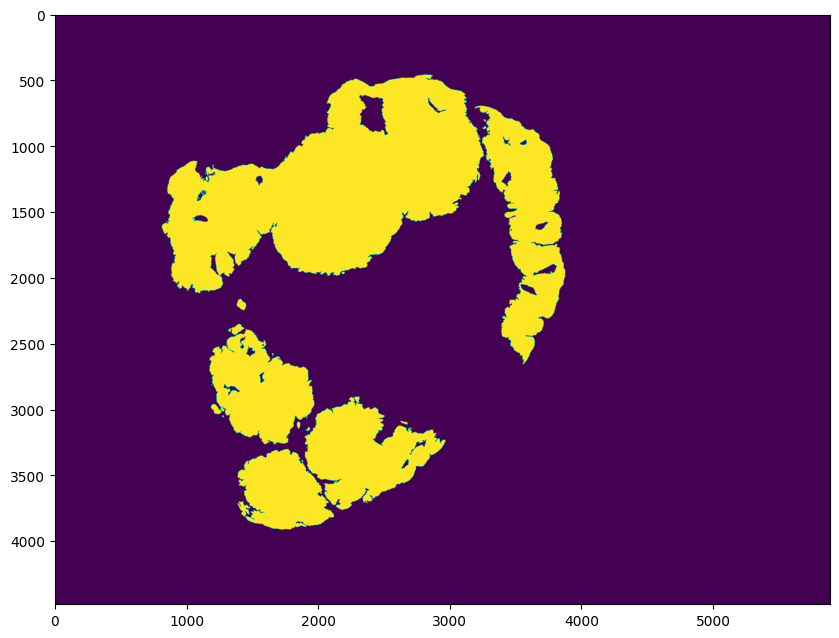

In [17]:

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=my_zoom_level, 
                        width=slide.level_dimensions[my_zoom_level][0], 
                        height=slide.level_dimensions[my_zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)


In [18]:
#defining some helper functions to get the tissue density in a slide and to apply a monotone mask on an image

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  

def apply_mask(im, mask, color):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [19]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models

2.4.0


Making a function to do data augmentation

In [20]:
def augmentation(x):
  
  #rotate 4 directions and left-right flip
  x1 = np.rot90(x,k=1)
  x2 = np.rot90(x1,k=1)
  x3 = np.rot90(x2,k=1)
  x4 = np.rot90(x3,k=1)
  x5 = x1[:, ::-1]
  x6 = x2[:,::-1]
  x7 = x3[:,::-1]
  x8 = x4[:,::-1]
  x_new= [x1,x2,x3,x4,x5,x6,x7,x8]
 
  return x_new

In [21]:
from tensorflow.python.keras.preprocessing import image

In [22]:
def prepare_data(slide, tumor_mask, level, window_size,
                           center_size,stride):
  
  factor = int(slide.level_downsamples[level])
  tumor_count = 1
  normal_count = 1
  x_step = (window_size[0]-center_size[0])//2
  y_step = (window_size[1]-center_size[1])//2
  imgs0 = []
  imgs1 = []
  
  for i in range(0, slide.level_dimensions[level][0]-window_size[0], stride):  
    for j in range(0, slide.level_dimensions[level][1]-window_size[1], stride): 
      slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
      tissue_pixels = list(find_tissue_pixels(np.asarray(slide_img)))
      mask_img = read_slide(tumor_mask, (i+x_step)*factor, (j+y_step)*factor, level, center_size[0], center_size[1], as_float=False)
      tissue_pixels = list(tissue_pixels)
      percent_tissue = len(tissue_pixels) / float(slide_img.shape[0] * slide_img.shape[0]) * 100 #percentage tissue in the patch
      if percent_tissue > 10: #percent tissue greater than 10 percent
        if np.sum(mask_img)==0:   #normal
          imgs0 += augmentation(image.img_to_array(slide_img)/255)
        elif np.sum(mask_img)!=0: #tumor
          imgs1 += augmentation(image.img_to_array(slide_img)/255)
        
  imgs = np.concatenate((np.asarray(imgs0),np.asarray(imgs1)))
  labels = np.append(np.repeat(0.,len(imgs0)),np.repeat(1.,len(imgs1)))
  ind = [i for i in range(labels.shape[0])]
  np.random.shuffle(ind)
  
  return imgs[ind], labels[ind]

setting parameters

In [23]:
window_size=(80,80)
center_size=(50,50)
stride=50
level=4 #zoom level
IMG_SIZE=80

preparing data at level 4

In [24]:

patches, labels= prepare_data(slide, tumor_mask, level=level, window_size=window_size,center_size=center_size,
                           stride=stride)

In [25]:
patches.shape

(36408, 80, 80, 3)

In [26]:
labels.shape

(36408,)

In [27]:

np.unique(labels,return_counts=True)

(array([0., 1.]), array([20672, 15736]))

In [28]:
one_counter = 0
zero_counter = 0

for i in range(0, labels.shape[0]):
  if labels[i] == 0:
    zero_counter += 1
  else:
    one_counter += 1
    
    
print(" Number of Ones = ", one_counter)
print(" Number of Zeroes = ", zero_counter)

 Number of Ones =  15736
 Number of Zeroes =  20672


calculating class weights to deal with class imbalance

In [29]:
total = one_counter + zero_counter

weight_for_0 = (1 / zero_counter)*(total)/2.0 
weight_for_1 = (1 / one_counter)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.8806114551083591, 1: 1.1568378240976105}


used transfer learning

In [30]:
base_model=tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False)

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten=tf.keras.layers.Flatten()
dense_l=tf.keras.layers.Dense(128, activation='relu')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
drop_layer = tf.keras.layers.Dropout(0.5)

# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  flatten,
  dense_l,
  drop_layer,
  prediction_layer
])

model.compile(loss='binary_crossentropy',
              optimizer ='adam',
              metrics=tf.keras.metrics.AUC(name='auc'))

model.fit(patches,labels,epochs=10,batch_size=32,validation_split=0.2,class_weight=class_weight)

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/10
911/911 [==============================] - 35s 29ms/step - loss: 0.3642 - auc: 0.9123 - val_loss: 0.1890 - val_auc: 0.9784
Epoch 2/10
911/911 [==============================] - 26s 28ms/step - loss: 0.2015 - auc: 0.9745 - val_loss: 0.1702 - val_auc: 0.9822
Epoch 3/10
911/911 [==============================] - 26s 29ms/step - loss: 0.1855 - auc: 0.9779 - val_loss: 0.1578 - val_auc: 0.9834
Epoch 4/10
911/911 [==============================] - 27s 29ms/step - loss: 0.1662 - auc: 0.9822 - val_loss: 0.1481 - val_auc: 0.9858
Epoch 5/10
911/911 [==============================] - 28s 30ms/step - loss: 0.1665 - auc: 0.9819 - val_loss: 0.1420 - val_auc: 0.9858
Epoch 6/10
911/911 [==============================] - 27s 30ms/step - loss: 0.1619 - auc: 0.9832 - val_loss: 0.1428 - val_auc: 0.9861
Epoch 7/10
911/911 [==============================] - 27s 30ms/step - loss: 0.1489 - auc: 0.9856 - val_loss: 0.1355 - val_auc: 0.98

test

In [31]:

## convert labels to mask
def make_mask(y_pred, mask_size, window_size,center_size,stride):
  
  mask_pred=np.zeros((mask_size[1],mask_size[0]))
  count=0
  x_grid=center_size[0]//2
  y_grid=center_size[1]//2
  for j in range(0,mask_size[0]-window_size[0],stride):    
    for i in range(0,mask_size[1]-window_size[1],stride):  
      x_pos=i+window_size[0]//2
      y_pos=j+window_size[1]//2
      if count >= len(y_pred):
        count -= 1
      mask_pred[(x_pos-x_grid):(x_pos+x_grid),(y_pos-y_grid):(y_pos+y_grid)]=y_pred[count]
      count += 1
  return(mask_pred)

In [32]:
def pred(model, slide, level, window_size,
                     center_size,stride):
  
  factor = int(slide.level_downsamples[level])
  preds = []
  for i in range(0, slide.level_dimensions[level][0]-window_size[0],stride):  
    for j in range(0, slide.level_dimensions[level][1]-window_size[1],stride): 
      slide_img = read_slide(slide, i*factor, j*factor, level, window_size[0], window_size[1], as_float=False)
      patch = image.img_to_array(slide_img)/255
      #making sure the dimensions match
      pred = model.predict(np.expand_dims(patch.astype('float32'),axis=0))
      preds.append(pred)
  
  mask_pred = make_mask(np.asarray(preds), slide.level_dimensions[level], window_size = window_size, 
                         center_size=center_size, stride = stride)
  return mask_pred

In [34]:

mask_pred = pred(model, slide_test, level, window_size=window_size,
                          center_size=center_size,stride=stride)

Visualizing heatmap for the predictions

In [35]:

slide_image_test = np.asarray(read_slide(slide_test, x=0, y=0, 
                         level=level, 
                         width=slide_test.level_dimensions[level][0], 
                         height=slide_test.level_dimensions[level][1]))
mask_image_test = np.asarray(read_slide(tumor_mask_test, x=0, y=0, 
                        level=level, 
                        width=slide_test.level_dimensions[level][0], 
                        height=slide_test.level_dimensions[level][1]))
mask_image_test = mask_image_test[:,:,0]

Text(0.5, 1.0, 'predictions')

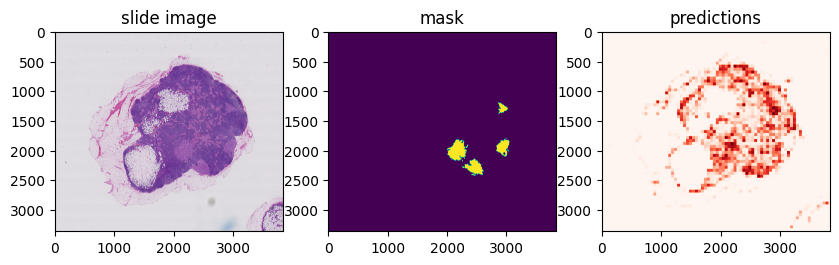

In [36]:
plt.figure(figsize = (10,20), dpi = 100)

plt.subplot(1, 3, 1)
plt.imshow(slide_image_test)
plt.title("slide image")

plt.subplot(1, 3, 2)
plt.imshow(mask_image_test)
plt.title("mask")

plt.subplot(1, 3, 3)
plt.imshow(mask_pred, cmap='Reds')
plt.title("predictions")

In [37]:
from sklearn import metrics
import sklearn
from sklearn.metrics import confusion_matrix

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(mask_image_test.reshape(-1).astype('float32'), 
                                        mask_pred.reshape(-1), pos_label=None)
print('AUC:%s'%(metrics.auc(fpr, tpr)))

AUC:0.9437405904845956


In [39]:
from sklearn.metrics import classification_report

In [50]:
print(classification_report(mask_image_test.reshape(-1).astype('float32'), np.round(mask_pred.reshape(-1))))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98  12715351
         1.0       0.15      0.49      0.23    187049

    accuracy                           0.95  12902400
   macro avg       0.57      0.73      0.60  12902400
weighted avg       0.98      0.95      0.96  12902400

